# Análisis de Evasión según Variables Categóricas - Telecom X

## Propósito
En este cuaderno, se analiza cómo se distribuye la variable `Evasión` en función de variables categóricas como `Género`, `Contrato`, `Método_Pago`, `Servicio_Internet` y `Facturación_Sin_Papel`. Se utilizan gráficos variados para identificar patrones en la propensión a cancelar el servicio.

## Tarea
1. Cargar el dataset estandarizado desde la URL de la API y aplicar transformaciones previas.
2. Traducir los valores de variables categóricas a español.
3. Crear gráficos variados (barras apiladas, mosaico, barras agrupadas, proporciones).
4. Guardar las visualizaciones como PNG en la carpeta `img/`.
5. Interpretar los patrones observados.

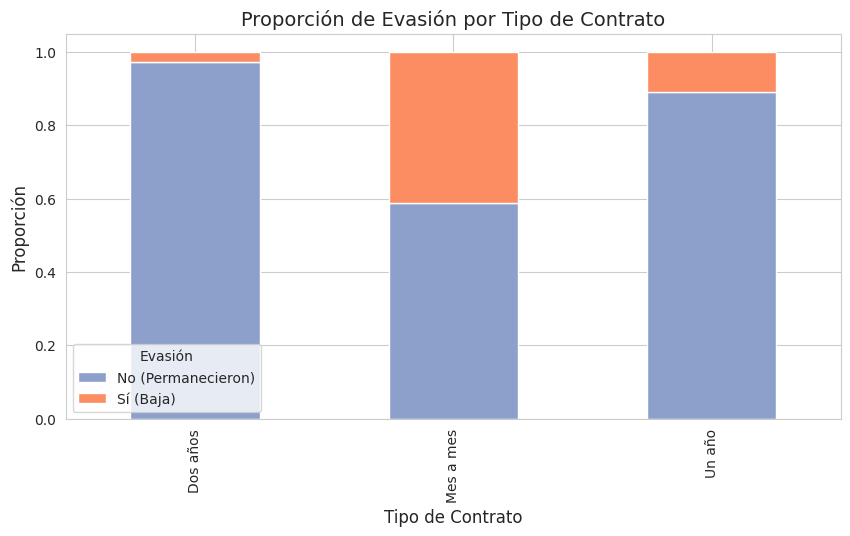

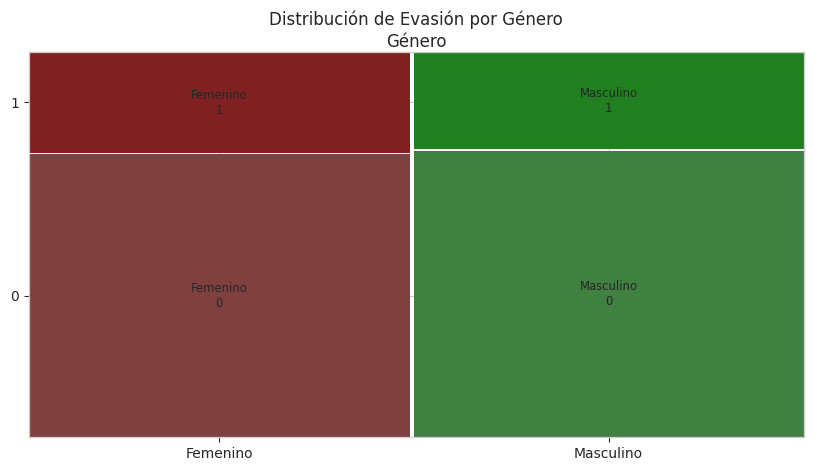

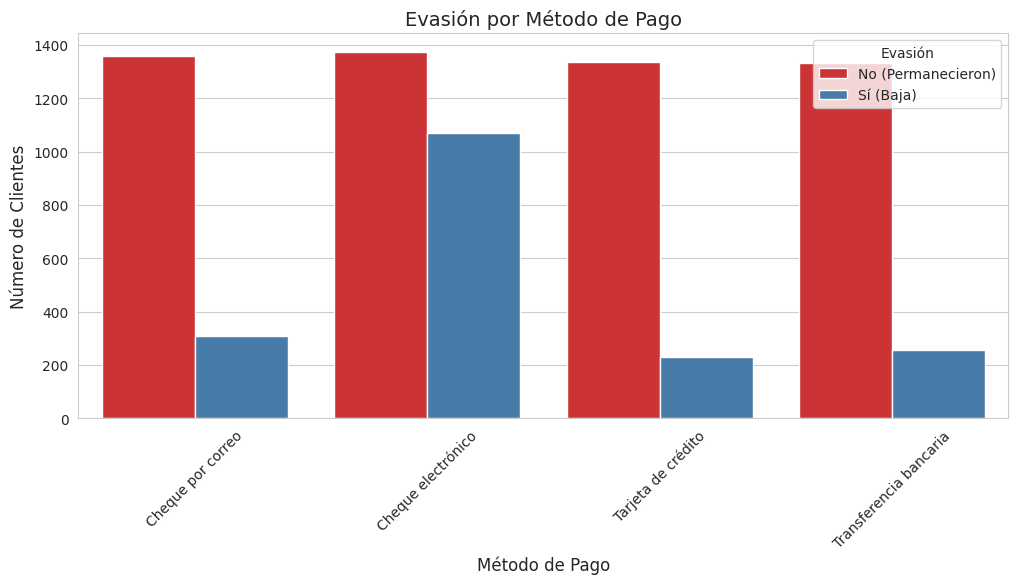

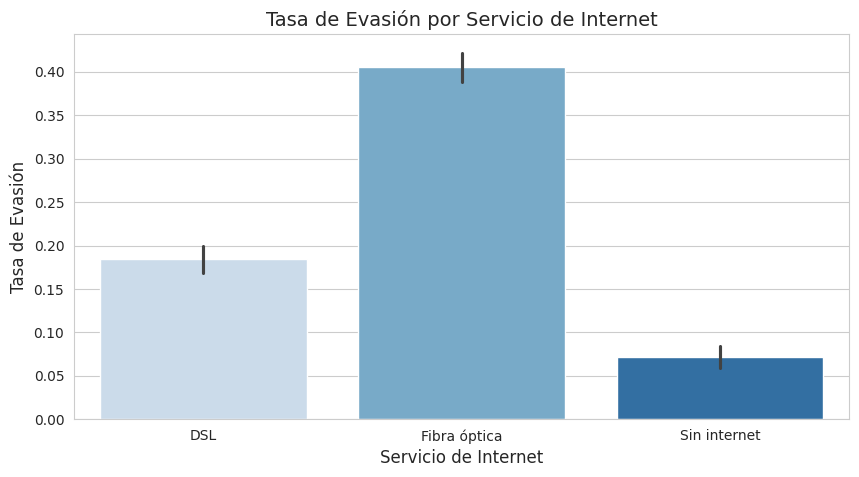

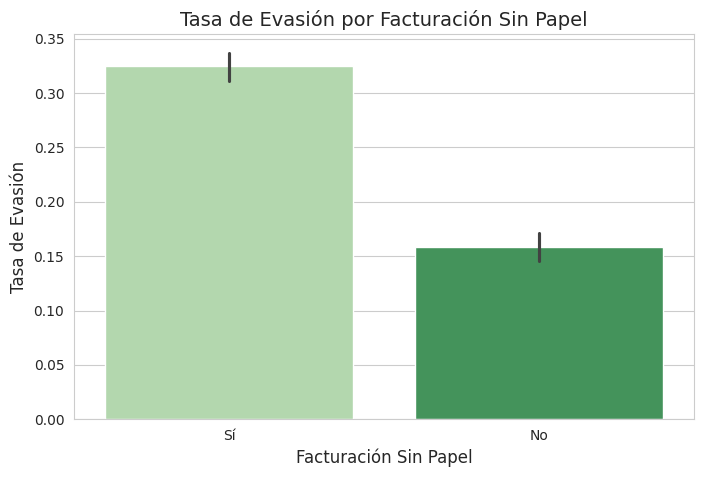


Gráficos guardados como:
- evasion_por_contrato.png
- evasion_por_genero.png
- evasion_por_metodo_pago.png
- evasion_por_servicio_internet.png
- evasion_por_facturacion.png


In [6]:
# Importación de bibliotecas
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Carga de datos con manejo de errores
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
try:
    response = requests.get(url)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa
except requests.exceptions.RequestException as e:
    print(f"Error al descargar los datos: {e}")
    raise

# Verificar el contenido de la respuesta
try:
    data = response.json()
except json.JSONDecodeError as e:
    print(f"Error al decodificar JSON: {e}")
    print("Contenido de la respuesta:", response.text[:500])
    raise

# Conversión a DataFrame
df = pd.DataFrame(data)

# Desanidar columnas JSON
customer_df = pd.json_normalize(df['customer'])
customer_df.columns = [f"customer_{col}" for col in customer_df.columns]
phone_df = pd.json_normalize(df['phone'])
phone_df.columns = [f"phone_{col}" for col in phone_df.columns]
internet_df = pd.json_normalize(df['internet'])
internet_df.columns = [f"internet_{col}" for col in internet_df.columns]
account_df = pd.json_normalize(df['account'])
account_df.columns = [f"account_{col}" for col in account_df.columns]

# Combinar los datos desanidados
df_clean = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)

# Aplicar correcciones previas
df_clean['Churn'] = df_clean['Churn'].replace('', 'No')
df_clean['account_Charges.Monthly'] = pd.to_numeric(df_clean['account_Charges.Monthly'], errors='coerce')
df_clean['account_Charges.Total'] = pd.to_numeric(df_clean['account_Charges.Total'], errors='coerce')
df_clean['customer_tenure'] = df_clean['customer_tenure'].astype('int64')
df_clean['customer_SeniorCitizen'] = df_clean['customer_SeniorCitizen'].astype('int64')

# Imputar valores nulos en 'account_Charges.Total'
median_total = df_clean['account_Charges.Total'].median()
df_clean['account_Charges.Total'] = df_clean.apply(
    lambda row: row['account_Charges.Monthly'] if pd.isna(row['account_Charges.Total']) and row['customer_tenure'] <= 1
    else row['account_Charges.Total'] if not pd.isna(row['account_Charges.Total'])
    else median_total,
    axis=1
)

# Crear la columna 'Cuentas_Diarias'
df_clean['Cuentas_Diarias'] = df_clean['account_Charges.Monthly'] / 30

# Estandarizar variables binarias
binary_columns = [
    'Churn', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService',
    'account_PaperlessBilling', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
    'internet_StreamingMovies'
]
for col in binary_columns:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Renombrar columnas
column_mapping = {
    'customerID': 'ID_Cliente', 'Churn': 'Evasión', 'customer_gender': 'Género',
    'customer_SeniorCitizen': 'Ciudadano_Senior', 'customer_Partner': 'Pareja',
    'customer_Dependents': 'Dependientes', 'customer_tenure': 'Antigüedad',
    'phone_PhoneService': 'Servicio_Telefónico', 'phone_MultipleLines': 'Líneas_Múltiples',
    'internet_InternetService': 'Servicio_Internet', 'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online', 'internet_DeviceProtection': 'Protección_Dispositivo',
    'internet_TechSupport': 'Soporte_Técnico', 'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Películas', 'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Facturación_Sin_Papel', 'account_PaymentMethod': 'Método_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales', 'account_Charges.Total': 'Cargos_Totales',
    'Cuentas_Diarias': 'Cargos_Diarios'
}
df_clean = df_clean.rename(columns=column_mapping)

# Traducir valores categóricos a español
df_clean['Género'] = df_clean['Género'].map({'Male': 'Masculino', 'Female': 'Femenino'})
df_clean['Contrato'] = df_clean['Contrato'].map({
    'Month-to-month': 'Mes a mes', 'One year': 'Un año', 'Two year': 'Dos años'
})
df_clean['Método_Pago'] = df_clean['Método_Pago'].map({
    'Electronic check': 'Cheque electrónico', 'Mailed check': 'Cheque por correo',
    'Bank transfer (automatic)': 'Transferencia bancaria', 'Credit card (automatic)': 'Tarjeta de crédito'
})
df_clean['Servicio_Internet'] = df_clean['Servicio_Internet'].map({
    'Fiber optic': 'Fibra óptica', 'DSL': 'DSL', 'No': 'Sin internet'
})
df_clean['Facturación_Sin_Papel'] = df_clean['Facturación_Sin_Papel'].map({1: 'Sí', 0: 'No'})

# 1. Gráfico de barras apiladas para 'Contrato'
cross_tab = pd.crosstab(df_clean['Contrato'], df_clean['Evasión'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, color=['#8da0cb', '#fc8d62'], figsize=(10, 5))
plt.title('Proporción de Evasión por Tipo de Contrato', fontsize=14)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Proporción', fontsize=12)
plt.legend(['No (Permanecieron)', 'Sí (Baja)'], title='Evasión')
plt.savefig('evasion_por_contrato.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2. Gráfico de mosaico para 'Género'
mosaic(df_clean, ['Género', 'Evasión'], title='Distribución de Evasión por Género', axes_label=True)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Evasión (0 = No, 1 = Sí)', fontsize=12)
plt.savefig('evasion_por_genero.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 3. Gráfico de barras agrupadas para 'Método_Pago'
plt.figure(figsize=(12, 5))
sns.countplot(x='Método_Pago', hue='Evasión', data=df_clean, palette='Set1')
plt.title('Evasión por Método de Pago', fontsize=14)
plt.xlabel('Método de Pago', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['No (Permanecieron)', 'Sí (Baja)'], title='Evasión')
plt.savefig('evasion_por_metodo_pago.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 4. Gráfico de proporciones para 'Servicio_Internet'
plt.figure(figsize=(10, 5))
sns.barplot(x='Servicio_Internet', y='Evasión', hue='Servicio_Internet', data=df_clean, palette='Blues', legend=False)
plt.title('Tasa de Evasión por Servicio de Internet', fontsize=14)
plt.xlabel('Servicio de Internet', fontsize=12)
plt.ylabel('Tasa de Evasión', fontsize=12)
plt.savefig('evasion_por_servicio_internet.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 5. Gráfico de proporciones para 'Facturación_Sin_Papel'
plt.figure(figsize=(8, 5))
sns.barplot(x='Facturación_Sin_Papel', y='Evasión', hue='Facturación_Sin_Papel', data=df_clean, palette='Greens', legend=False)
plt.title('Tasa de Evasión por Facturación Sin Papel', fontsize=14)
plt.xlabel('Facturación Sin Papel', fontsize=12)
plt.ylabel('Tasa de Evasión', fontsize=12)
plt.savefig('evasion_por_facturacion.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6. Confirmación de guardado
print("\nGráficos guardados como:")
print("- evasion_por_contrato.png")
print("- evasion_por_genero.png")
print("- evasion_por_metodo_pago.png")
print("- evasion_por_servicio_internet.png")
print("- evasion_por_facturacion.png")

## Descripción de la tarea
En esta sección, se analizó la distribución de `Evasión` según variables categóricas (`Género`, `Contrato`, `Método_Pago`, `Servicio_Internet`, `Facturación_Sin_Papel`) usando gráficos variados:
- Barras apiladas para `Contrato`, mostrando proporciones de evasión.
- Gráfico de mosaico para `Género`, visualizando la relación con evasión.
- Barras agrupadas para `Método_Pago`, comparando número de clientes.
- Gráficos de proporciones para `Servicio_Internet` y `Facturación_Sin_Papel`, mostrando tasas de evasión.
Los valores categóricos se tradujeron a español para los ejes. Las visualizaciones se guardaron en `img/` como PNG.